# **Práctica 10: Archivos.**

## **Clases de Modelos**

In [ ]:
import os
import json
from datetime import datetime
import matplotlib.pyplot as plt

class User:
    def __init__(self, user_id, name, password):
        self.id = user_id
        self.name = name
        self.password = password

class File:
    def __init__(self, file_id, name, id_owner, name_owner, content=""):
        self.key = file_id
        self.name = name
        self.id_owner = id_owner
        self.name_owner = name_owner
        self.content = content
    
    def __str__(self):
        return f"Información del archivo:\nID: {self.key},\nNombre: {self.name},\nPropietario: {self.name_owner}"

class Session:
    def __init__(self, user_id, isValid=True):
        self.user_id = user_id
        self.datetime = datetime.now()
        self.isValid = isValid
    
    def __str__(self):
        return f"Session(UserID={self.user_id}, Fecha={self.datetime}, Válido={self.isValid})"
    
class IndexEntry:
    def __init__(self, file_name, primary_id):
        self.key = file_name 
        self.value = primary_id

## **Árbol B**

In [53]:
class Data:
    def __init__(self, key, value):
        self.key = key
        self.value = value

    def __str__(self):
        return str(self.key) + "->" + self.value

class BTreeNode:
    def __init__(self, t, leaf):
        self.t = t
        self.keys = [None] * (2 * t - 1)
        self.C = [None] * (2 * t)
        self.n = 0
        self.leaf = leaf

    def insertNonFull(self, data):
        i = self.n - 1
        if self.leaf:
            while i >= 0 and self.keys[i].key > data.key:
                self.keys[i + 1] = self.keys[i]
                i -= 1
            self.keys[i + 1] = data
            self.n += 1
        else:
            while i >= 0 and self.keys[i].key > data.key:
                i -= 1
            if self.C[i + 1].n == 2 * self.t - 1:
                self.splitChild(i + 1, self.C[i + 1])
                if self.keys[i + 1].key < data.key:
                    i += 1
            self.C[i + 1].insertNonFull(data)

    def splitChild(self, i, y):
        z = BTreeNode(y.t, y.leaf)
        z.n = self.t - 1
        for j in range(self.t - 1):
            z.keys[j] = y.keys[j + self.t]
        if not y.leaf:
            for j in range(self.t):
                z.C[j] = y.C[j + self.t]
        y.n = self.t - 1
        for j in range(self.n, i, -1):
            self.C[j + 1] = self.C[j]
        self.C[i + 1] = z
        for j in range(self.n - 1, i - 1, -1):
            self.keys[j + 1] = self.keys[j]
        self.keys[i] = y.keys[self.t - 1]
        self.n += 1

    def traverse(self, output_list):
        for i in range(self.n):
            if not self.leaf:
                self.C[i].traverse(output_list)
            output_list.append(self.keys[i])
        if not self.leaf:
            self.C[self.n].traverse(output_list)

    def search(self, k):
        i = 0
        while i < self.n and k > self.keys[i].key:
            i += 1
        if i < self.n and k == self.keys[i].key:
            return self.keys[i]
        if self.leaf:
            return None
        return self.C[i].search(k)

class BTree:
    def __init__(self, t):
        self.root = None
        self.t = t

    def traverse(self):
        output_list = []
        if self.root != None:
            self.root.traverse(output_list)
        return output_list

    def search(self, k):
        return None if self.root == None else self.root.search(k)

    def insert(self, data):
        if self.root == None:
            self.root = BTreeNode(self.t, True)
            self.root.keys[0] = data
            self.root.n = 1
        else:
            if self.root.n == 2 * self.t - 1:
                s = BTreeNode(self.t, False)
                s.C[0] = self.root
                s.splitChild(0, self.root)
                i = 0
                if s.keys[0].key < data.key:
                    i += 1
                s.C[i].insertNonFull(data)
                self.root = s
            else:
                self.root.insertNonFull(data)


## **Funciones para Gestionar JSON**

In [54]:
class JsonController:
    def __init__(self):
        self.p_Tree = BTree(2)
        self.n_Tree = BTree(2)
        self.sessions = []
        self.file_counters = {}
        self.permits = {}
        self.import_sessions()
        self.import_files()
        self.import_permits()
        self.save_sessions()
    
    def import_sessions(self):
        try:
            if os.path.exists("sessions.json"):
                with open("sessions.json", "r", encoding="utf-8") as file:
                    sessions_data = json.load(file)
                    for session_data in sessions_data:
                        session = Session(
                            session_data["user_id"],
                            session_data["isValid"]
                        )
                        session.datetime = datetime.fromisoformat(session_data["datetime"])
                        self.sessions.append(session)
        except Exception as e:
            print(f"Error al cargar sesiones: {e}")

    def import_files(self):
        try:
            if os.path.exists("files.json"):
                with open("files.json", "r", encoding="utf-8") as file:
                    files_data = json.load(file)
                    for file_data in files_data:
                        nuevo_archivo = File(file_data["id"], file_data["name"], file_data["id_owner"], file_data["name_owner"], file_data["content"])
                        self.p_Tree.insert(nuevo_archivo)
                        index_entry = IndexEntry(nuevo_archivo.name, nuevo_archivo.key)
                        self.n_Tree.insert(index_entry)
                print("Se cargaron correctamente los archivos")
        except Exception as e:
            print(f"Error al cargar archivos: {e}")

    def import_permits(self):
        try:
            if os.path.exists("permits.json"):
                with open("permits.json", "r", encoding="utf-8") as file:
                    permits_data = json.load(file)
                    for user_entry in permits_data:
                        user_id = user_entry["id_user"]
                        permisos = {int(k): v for k, v in user_entry.items() if k != "id_user"}
                        self.permits[user_id] = permisos
                print("Se cargaron correctamente los permisos")
        except Exception as e:
            print(f"Error al cargar permisos: {e}")

    def save_session(self, session):
        self.sessions.append(session)
        self.save_sessions()
    
    def save_sessions(self):
        try:
            sessions_data = []
            for session in self.sessions:
                session_data = {
                    "user_id": session.user_id,
                    "datetime": session.datetime.isoformat(),
                    "isValid": session.isValid
                }
                sessions_data.append(session_data)
            
            with open("sessions.json", "w", encoding="utf-8") as file:
                json.dump(sessions_data, file, indent=2)
        except Exception as e:
            print(f"Error al guardar sesiones: {e}")

    def verify_user(self, user_id, password):
        try:
            if not os.path.exists("users.json"):
                print("Error: Archivo users.json no encontrado")
                return None
            
            with open("users.json", "r", encoding="utf-8") as file:
                users_data = json.load(file)
            
            for user_data in users_data:
                if str(user_data.get("id")) == user_id and user_data.get("password") == password:
                    return User(user_id, user_data["name"], password)
            
            return None
            
        except Exception as e:
            print(f"Error al leer users.json: {e}")
            return None

    def search_file_name(self, file_name):
        index_entry = self.n_Tree.search(file_name) 
        if index_entry:
            file_id = index_entry.value
            return self.p_Tree.search(file_id)
        else: return None

    def generate_id(self):
        max_id = 0
        archivos_list = self.p_Tree.traverse() 
        for archivo in archivos_list:
            if archivo.key > max_id: 
                max_id = archivo.key
        return max_id + 1

    def save_file(self, file):
        self.p_Tree.insert(file)
        index_entry = IndexEntry(file.name, file.key)
        self.n_Tree.insert(index_entry)
        self.update_files()

    def update_files(self):
        try:
            archivos_list = self.p_Tree.traverse() 
            
            files_data = []
            for archivo in archivos_list:
                file_data = {
                    "id": int(archivo.key),
                    "id_owner": archivo.id_owner, 
                    "name_owner": archivo.name_owner,
                    "name": archivo.name,
                    "content": archivo.content
                }
                files_data.append(file_data)
            
            with open("files.json", "w", encoding="utf-8") as file:
                json.dump(files_data, file, indent=2)
                
            print("Archivo files.json actualizado.")
            
        except Exception as e:
            print(f"Error al actualizar files.json: {e}")

    def get_files(self, user_id):
        archivos_permitidos_ids = set()
        user_permits = self.permits.get(user_id)
        
        if user_permits:
            for _, file_ids in user_permits.items():
                for file_id in file_ids:
                    archivos_permitidos_ids.add(int(file_id)) 
        
        return list(archivos_permitidos_ids)

    def assign_permit(self, user_id, file_id, level):
        user_id_str = str(user_id)
        file_id_int = int(file_id)
        
        if user_id_str not in self.permits:
            self.permits[user_id_str] = {}
        
        for existing_level in range(1, 10):
            if existing_level != level and existing_level in self.permits[user_id_str]:
                if file_id_int in self.permits[user_id_str][existing_level]:
                    self.permits[user_id_str][existing_level].remove(file_id_int)
                    
        if level not in self.permits[user_id_str]:
            self.permits[user_id_str][level] = []
        
        if file_id_int not in self.permits[user_id_str][level]:
            self.permits[user_id_str][level].append(file_id_int)
        
        self.update_permits()

    def update_permits(self):
        try:
            permits_data = []
            
            for user_id, permisos in self.permits.items():
                user_entry = {"id_user": user_id}
                for level, file_ids in permisos.items():
                    user_entry[str(level)] = file_ids
                permits_data.append(user_entry)
            
            with open("permits.json", "w", encoding="utf-8") as file:
                json.dump(permits_data, file, indent=4)
            
            print("Archivo permits.json actualizado.")
            
        except Exception as e:
            print(f"Error al guardar permits.json: {e}")

    def contar_sessions(self):
        conteo = {}
        for session in self.sessions:
            user_id = session.user_id
            if user_id not in conteo:
                conteo[user_id] = {'validos': 0, 'invalidos': 0}
            
            if session.isValid:
                conteo[user_id]['validos'] += 1
            else:
                conteo[user_id]['invalidos'] += 1
        return conteo
    
    def contar_levels(self, user_id):
        user_permits = self.permits.get(user_id)
        if not user_permits:
            return {}
        
        conteo_niveles = {}
        for level, file_ids in user_permits.items():
            conteo_niveles[level] = len(file_ids)
            
        return conteo_niveles

## **Clase del Sistema**

In [ ]:
class FileSystem:
    def __init__(self):
        self.j_controller = JsonController()
        self.curr_user = None
        self.curr_session = None
    
    def login(self, user_id, password):
        usuario = self.j_controller.verify_user(user_id, password)
        if usuario:
            self.curr_user = usuario
            self.curr_session = Session(user_id, True)
            self.j_controller.save_session(self.curr_session)
            print(f"¡Bienvenid@ {usuario.name}!")
            return True
        else:
            failed = Session(user_id, False)
            self.j_controller.save_session(failed)
            print("Error: ID de usuario o contraseña incorrectos")
            return False
    
    def logout(self):
        if self.curr_user:
            print(f"=============== Sesión cerrada para {self.curr_user.name} ===============")
            self.curr_user = None
            self.curr_session = None
        else: print("No hay sesión activa")

    def search_file(self, file_name):
        if not self.curr_user:
            print("Error: Debe iniciar sesión primero para buscar archivos.")
            return

        archivo = self.j_controller.search_file_name(file_name)

        if not archivo:
            print(f"Error: El archivo '{file_name}' no existe o no se encontró.")
            return

        user_id = self.curr_user.id
        level = self.get_level(user_id, archivo.key)
        if level is None: level = 0
        if level < 2:
            print(f"No tienes el nivel de acceso suficiente para visualizar el archivo '{file_name}'.")
            return
            
        print(f"\n--- Información y Permisos para el archivo: '{archivo.name}' (ID: {archivo.key}) ---")
        print(f"Propietario: {archivo.name_owner}")
        
        print("\nAcciones que puedes realizar:")
        if level == 2: print("- Puedes saber quien es el propietario (Conocimiento)")
        if level == 3: print("- Puedes ejecutarlo (Ejecución)")
        if level == 4: print("- Puedes leerlo (Lectura)")
        if level == 5: print("- Puedes modificarlo (Escritura)")
        if level == 6: print("- Puedes agregar contenido pero no eliminar o modificar (Agregar)")
        if level == 7: print("- Puedes modificar, borrar  agregar contenido (Actualizar)")
        if level == 8: print("- Puedes ver quienes tienen pemisos sobre el archivo y modificarlos (Modificar Permisos)")
        if level == 9: print("- Puedes borrar el archivo (Borrar)")
    
    def get_level(self, user_id, file_id):
        user_permits = self.j_controller.permits.get(user_id, {})
        for level, file_ids in user_permits.items():
            if file_id in file_ids:
                return level
        return 0
    
    def create_file(self, file_name, content="", permissions=None):
        if not self.curr_user:
            print("Error: Debe iniciar sesión para crear un archivo.")
            return

        user_id = self.curr_user.id
        user_name = self.curr_user.name
        
        new_file_id = self.j_controller.generate_id()
        new_file = File(new_file_id, file_name, user_id, user_name, content)
        
        self.j_controller.save_file(new_file)
        
        print(f"\nArchivo '{file_name}' (ID: {new_file_id}) creado exitosamente.")
        print("Asignando permisos...")
        
        for target_user_id, access_level in permissions.items():
            target_user_id_str = str(target_user_id)
            
            if 1 <= access_level <= 9:
                self.j_controller.assign_permit(target_user_id_str, new_file_id, access_level)
                print(f" -> Permiso Nivel {access_level} asignado al Usuario ID: {target_user_id_str}.")
            else:
                print(f" -> Advertencia: Nivel de acceso {access_level} inválido para el Usuario ID: {target_user_id_str}. Ignorado.")

    def list_my_files(self):
        if not self.curr_user:
            print("Error: Debe iniciar sesión primero")
            return

        archivos_accesibles = []
        user_id = self.curr_user.id
        archivos_permitidos_ids = self.j_controller.get_files(user_id) 
        
        archivos_list = self.j_controller.p_Tree.traverse()
        archivos_completos = {archivo.key: archivo for archivo in archivos_list} 

        for file_id in archivos_permitidos_ids:
            archivo = archivos_completos.get(file_id)
            
            if archivo:
                level_access = self.get_level(user_id, file_id) 
                
                if level_access >= 1: 
                    archivos_accesibles.append(archivo)
        
        if not archivos_accesibles:
            print("No tienes archivos accesibles en el sistema")
            return
        
        print(f"\nArchivos accesibles ({len(archivos_accesibles)}):")
        for archivo in archivos_accesibles:
            print(f"- Nombre: {archivo.name}")

    def graph_sessions(self, user_id=None):
        conteo = self.j_controller.contar_sessions()
        if not conteo:
            print("No hay datos de sesiones para graficar.")
            return

        if user_id:
            if user_id in conteo:
                data_to_plot = {user_id: conteo[user_id]}
                title = f'Intentos de Sesión (Válidos vs. Inválidos) para Usuario {user_id}'
                file_name = f'intentos_sesion_user_{user_id}.png'
            else:
                print(f"No hay datos de sesiones para el usuario {user_id}.")
                return
        else:
            data_to_plot = conteo
            title = 'Intentos de Sesión (Válidos vs. Inválidos) por Usuario (Todos)'
            
        users = list(data_to_plot.keys())
        validos = [data['validos'] for data in data_to_plot.values()]
        invalidos = [data['invalidos'] for data in data_to_plot.values()]
        
        x = range(len(users))
        width = 0.35
        plt.figure(figsize=(max(8, len(users) * 0.8), 6))
        plt.bar([i - width/2 for i in x], validos, width, label='Válidos', color='green')
        plt.bar([i + width/2 for i in x], invalidos, width, label='Inválidos', color='red')
        plt.xlabel('Usuario ID')
        plt.ylabel('Número de Intentos')
        plt.title(title)
        plt.xticks(x, users, rotation=45, ha='right')
        plt.legend()
        plt.tight_layout()

    def graph_levels(self, user_id=None):
        if not self.curr_user and not user_id:
            print("Error: Debe iniciar sesión o proporcionar un ID de usuario para graficar.")
            return
        target_user_id = user_id if user_id else self.curr_user.id
        conteo_niveles = self.j_controller.contar_levels(target_user_id)
        
        if not conteo_niveles:
            print(f"El Usuario ID '{target_user_id}' no tiene permisos asignados en permits.json.")
            return
        level_names = {1: "Ninguno", 2: "Conocimiento", 3: "Ejecución",4: "Lectura", 5: "Escritura", 6: "Agregar",7: "Actualizar", 8: "Modif. Permisos", 9: "Borrar"}
        
        labels = [level_names.get(level, f'Nivel {level}') for level in conteo_niveles.keys()]
        sizes = list(conteo_niveles.values())
        plt.figure(figsize=(10, 8))
        plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
        plt.title(f"Distribución de Niveles de Acceso para Usuario ID: {target_user_id}")
        plt.axis('equal')
        

## **Prueba**


=============== SISTEMA DE ARCHIVOS ===============
Se cargaron correctamente los archivos
Se cargaron correctamente los permisos

=============== LOGIN ===============
¡Bienvenid@ Olivia!
=============== Sesión cerrada para Olivia ===============


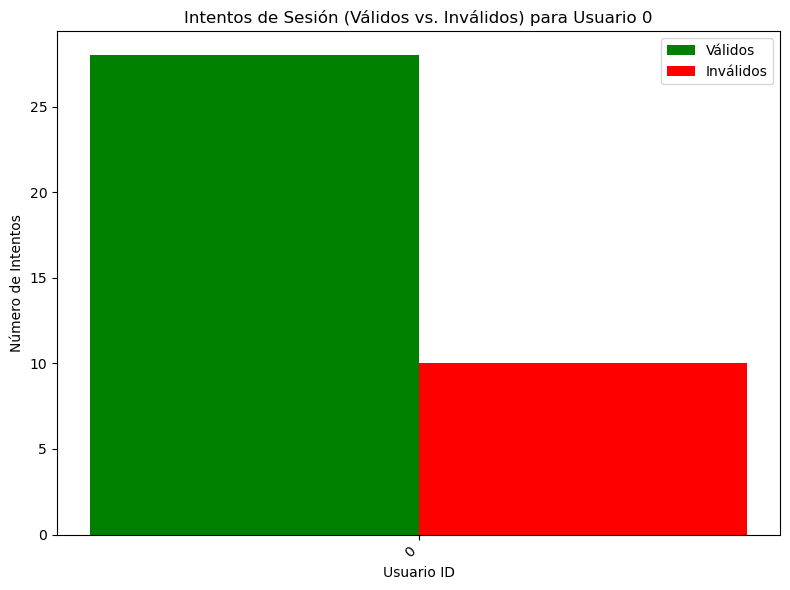

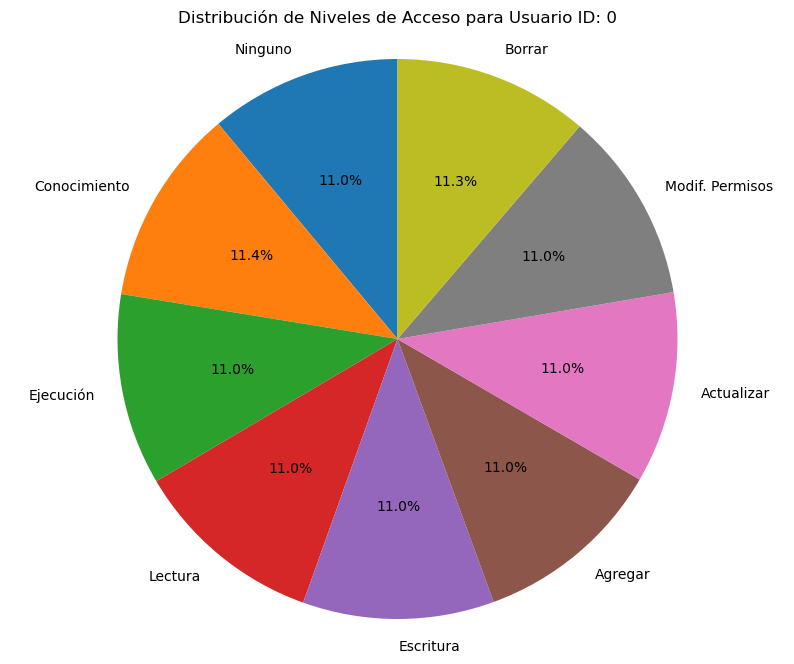

In [56]:
print("\n=============== SISTEMA DE ARCHIVOS ===============")
S = FileSystem()

id_user = "0"
password = "123456789"

print("\n=============== LOGIN ===============")
ini = S.login(id_user, password)

if ini:
    # print("\n=============== BUSCAR ARCHIVO ===============")
    # S.search_file("mitarea.txt")

    # print("\n=============== AGREGAR ARCHIVO ===============")
    # new_permits = {"0": 2,"1": 4,"5": 2}
    # S.create_file("mitarea.txt", "Contenido Confidencial.", new_permits)

    # print("\n=============== LISTAR ARCHIVOS ===============")
    # S.list_my_files()

    S.graph_sessions(id_user)
    S.graph_levels(id_user)

    S.logout()